In [27]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq

from IPython.display import Image, display

import os
from dotenv import load_dotenv

from langchain_tavily import TavilySearch

In [2]:
# Load .env file
load_dotenv()

# Initialize State 
class State(TypedDict):
    messages: Annotated[list, add_messages]

### LLMs

In [3]:
# LLMs
llm_google = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite')
llm_groq = ChatGroq(model='llama3-8b-8192')

llm = llm_google # Set default llm

### TOOLS

In [17]:
search_tool = TavilySearch(max_results=2)
search_tool.invoke("Agentic AI for beginners")

{'query': 'Agentic AI for beginners',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.youtube.com/watch?v=CnXdddeZ4tQ',
   'title': 'Agentic AI Tutorial for Beginners | Langgraph Tutorial - YouTube',
   'content': "Agentic AI Tutorial for Beginners | Langgraph Tutorial\ncodebasics\n1370000 subscribers\n2217 likes\n108549 views\n27 Jun 2025\nLearn Agentic AI using a popular framework langgraph. In this agenti ai tutorial for beginners, we will start with agentic AI basics and then we will dive deeper into langgraph by covering a wide range of topics.\n\n👉 Check out PyCharm, the IDE built for data science and AI/ML professionals: https://jb.gg/try-pycharm-now\n\n👉 Download PyCharm and use it for free forever, plus a one-month Pro subscription is included. \n\nCode: https://github.com/codebasics/langgraph-crash-course\n\n00:00 Introduction \n00:40 Agentic AI Basics\n00:00 What is Langgraph\n07:41 Langchain vs Langgraph\n13:08 Installation an

In [18]:
# Tool creation using a custom function
def calculate_bill_split(total_bill: float, num_people: int, tip_percentage: int) -> float:
    """
    Calculates the split amount for each person in the bill including the tip.
    
    Args:
        total_bill (float): The total bill amount.
        num_people (int): The number of people sharing the bill.
        tip_percentage (int): The tip percentage to be added to the bill.
    
    Returns:
        float: The amount each person needs to pay.
        
    """
    if num_people == 0:
        return 0.0
    total_with_tip = total_bill + (total_bill * tip_percentage / 100)
    return total_with_tip / num_people  

In [19]:
tools = [search_tool, calculate_bill_split]

In [20]:
# binding llm with tools
llm_with_tools = llm.bind_tools(tools)

### GRAPH

In [21]:
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state['messages'])]}

In [29]:
'''
BUUILDING THE GRAPH
'''
graph_builder = StateGraph(State)

# Nodes
graph_builder.add_node("tool_call_llm", tool_calling_llm)
graph_builder.add_node("tools", ToolNode(tools))

# Edges
graph_builder.add_edge(START, "tool_call_llm")
graph_builder.add_conditional_edges(
    "tool_call_llm",
    tools_condition
    
)
graph_builder.add_edge("tools", END)

# Compile
graph = graph_builder.compile()

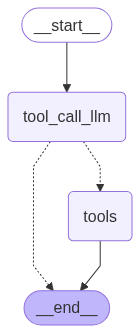

In [31]:
#visualize Graph
def display_graph():
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(f"Error displaying graph: {e}")

display_graph()


### Execute

In [33]:
response = graph.invoke({"messages": "How much do we have to split for our 53.98 USD bill if there are 4 of us and we want to tip 15%?"})
print(response['messages'])

[HumanMessage(content='How much do we have to split for our 53.98 USD bill if there are 4 of us and we want to tip 15%?', additional_kwargs={}, response_metadata={}, id='7d88b633-23c8-4a71-be4c-e1755fe0ef01'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'calculate_bill_split', 'arguments': '{"total_bill": 53.98, "tip_percentage": 15.0, "num_people": 4.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash-lite', 'safety_ratings': []}, id='run--b98f1311-bf68-45a6-ba5d-b11800260ddb-0', tool_calls=[{'name': 'calculate_bill_split', 'args': {'total_bill': 53.98, 'tip_percentage': 15.0, 'num_people': 4.0}, 'id': '3167b6c4-fd56-4811-b26b-6d8215a22aa5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1377, 'output_tokens': 38, 'total_tokens': 1415, 'input_token_details': {'cache_read': 0}}), ToolMessage(content='15.51925', name='calculate_bill_split', id='a93ebd3d-f3cf-47b9-b

In [34]:
response = graph.invoke({"messages": "How big is the land mass of USA?"})
print(response['messages'][-1].content)

{"query": "land mass of USA", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://data.census.gov/profile", "title": "Census Bureau Profiles Results", "content": "A **.gov** website belongs to an official government organization in the United States. Image 5: United States Census Bureau - Census Data Homepage The United States has a total area of 3,809,525 square miles, encompassing 3,532,316 square miles of land and 277,209 square miles of water, placing it among the five largest nations in terms of area. The United States has a total area of 3,809,525 square miles, encompassing 3,532,316 square miles of land and 277,209 square miles of water, placing it among the five largest nations in terms of area. Based on searching data.census.gov, I trust the information the U.S. Census Bureau is providing. Based on searching data.census.gov, I trust the information the U.S. Census Bureau is providing.", "score": 0.6786044, "raw_content": null}, {"url": "http

In [ ]:
for m in response['messages']:
    m.pretty_print()